<a href="https://colab.research.google.com/github/Tom-Ferrite/INFLUD/blob/main/Trabalho_Semestral_SRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pré-Processamento

Realização dos imports necessários para o código.

In [ ]:
import os
import zipfile
import requests
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

from collections import defaultdict

Configuração e carregamento dos datasets do OpenDataSUS. Aqui é interessante mencionar que, devido ao tamanho dos datasets, foi necessário quebrar cada .csv em diversas partes, que foram disponibilizadas no GitHub, para facilitar o processamento.

In [ ]:
zip_urls = [
    "https://github.com/Tom-Ferrite/INFLUD/raw/main/2020.zip",
    "https://github.com/Tom-Ferrite/INFLUD/raw/main/2021.zip",
]
folder_inside = "Tratados/"
sep = ","                      # você confirmou: vírgula
chunksize = 120_000
tmp_dir = "/tmp/influd_fg"
os.makedirs(tmp_dir, exist_ok=True)
max_collect = 200_000


In [ ]:
def binarize_flag_series(s):
    """Transforma coluna categórica em binária (1 = positivo, 0 = negativo)."""
    return s.astype(str).str.strip().str.upper().isin(["1", "SIM", "POS", "S"]).astype(int)

In [ ]:
def read_csv_chunks_from_zip_url(zip_url, folder_inside, chunksize, sep=","):
    """Lê CSVs de um ZIP hospedado via URL, em chunks."""
    print(f"\n Baixando ZIP: {zip_url}")
    response = requests.get(zip_url)
    response.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        inner_files = [f for f in z.namelist() if f.startswith(folder_inside) and f.endswith(".csv")]
        if not inner_files:
            print(" Nenhum CSV encontrado dentro da pasta:", folder_inside)
            return []

        for inner_name in inner_files:
            print(f" Encontrado: {inner_name}")
            with z.open(inner_name) as f:
                for chunk in pd.read_csv(f, sep=sep, chunksize=chunksize, dtype=str, low_memory=False):
                    yield inner_name, chunk

In [ ]:
def remover_colunas(df):
    colunas_para_remover = [
      'DT_NOTIFIC','SG_UF_NOT','ID_REGIONA','CO_REGIONA','ID_MUNICIP','CO_MUN_NOT','COD_IDADE',
      'CS_ETINIA','CS_ESCOL_N','ID_PAIS','CO_PAIS','SG_UF','ID_RG_RESI','CO_RG_RESI','ID_MN_RESI',
      'CO_MUN_RES','CS_ZONA','OUTRO_DES','MORB_DESC','DT_UT_DOSE',
      'MAE_VAC','DT_VAC_MAE','M_AMAMENTA','DT_DOSEUNI','DT_1_DOSE','DT_2_DOSE','SG_UF_INTE',
      'ID_RG_INTE','CO_RG_INTE','ID_MN_INTE','CO_MU_INTE','NM_UN_INTE','DT_RAIOX','AMOSTRA',
      'DT_COLETA','OUT_AMOST','DT_PCR','FLUASU_OUT','POS_PCROUT','PCR_OUTRO',
      'DS_PCR_OUT','CLASSI_OUT','CRITERIO','DT_DIGITA','HISTO_VGM','PAIS_VGM','CO_PS_VGM',
      'LO_PS_VGM','DT_VGM','DT_RT_VGM','PAC_COCBO','PAC_DSCBO','OUT_ANIM','TOMO_OUT','DT_TOMO',
      'TP_TES_AN','DT_RES_AN','POS_AN_OUT','DS_AN_OUT','TP_AM_SOR','SOR_OUT','DT_CO_SOR','TP_SOR',
      'OUT_SOR','DT_RES','RES_IGG','RES_IGM','RES_IGA','POV_CT','TP_POV_CT','TEM_CPF','ESTRANG',
      'DOSE_1_COV','DOSE_2_COV','DOSE_REF','DOSE_2REF','DOSE_ADIC','DOS_RE_BI','FAB_COV_1',
      'FAB_COV_2','FAB_COVRF','FAB_COVRF2','FAB_ADIC','FAB_RE_BI','LOTE_1_COV','LOTE_2_COV',
      'LOTE_REF','LOTE_REF2','LOTE_ADIC','LOT_RE_BI','FNT_IN_COV','DT_TRT_COV','OUT_TRAT',
      'VG_OMSOUT','VG_LIN','VG_MET','VG_METOUT','VG_DTRES','VG_ENC','VG_CODEST'
    ]
    df_sem_colunas = df.drop(columns=colunas_para_remover, errors='ignore')
    return df_sem_colunas

### Tratamento dos Dados e Montagem do DF

Colunas iniciais escolhidas

In [ ]:
col_interna = "DT_INTERNA"
col_evoluca = "DT_EVOLUCA"
col_evolucao_flag = "EVOLUCAO"   # 1 = cura/alta, 2 = óbito
col_antiv = "ANTIVIRAL"
col_tp_antiv = "TP_ANTIVIR"
col_age1 = "NU_IDADE_N"
col_age2 = "IDADE"
col_sex = "CS_SEXO"

# Variáveis clínicas + comorbidades
comorb_cols = [
    "OUT_MORBI", "DIABETES", "CARDIOPATI", "NOSOCOMIAL",
    "ASMA", "AVE_SUINO", "FEBRE", "TOSSE", "DISPNEIA",
    "GARGANTA", "DESC_RESP", "SATURACAO", "DIARREIA",
    "VOMITO", "DOR_ABD", "PERD_OLFT", "PERD_PALA",
    "FADIGA", "FATOR_RISC", "PUERPERA", "HEMATOLOGI",
    "SIND_DOWN", "HEPATICA", "RENAL", "IMUNODEPRE",
    "NEUROLOGIC", "PNEUMOPATI", "OBESIDADE", "OBES_IMC",
    "TABAG",
    # Variáveis adicionais
    "DT_INTERNA", "DT_EVOLUCA", "EVOLUCAO", "ANTIVIRAL",
    "NU_IDADE_N", "IDADE", "CS_SEXO", "SEM_PRI", "CS_GESTANT",
    "VACINA_COV", "VACINA", "OUT_ANTIV", "HOSPITAL", "UTI",
    "DT_ENTUTI", "DT_SAIDUTI", "SUPORT_VEN", "RAIOX_RES",
    "TOMO_RES", "TP_AMOSTRA", "POS_AN_FLU", "TP_FLU_AN",
    "CO_DETEC", "CLASSI_FIN"
]

In [ ]:
rows = []
collected = 0
max_collect = 1_000_000  # limite máximo opcional

for zip_url in zip_urls:
    for inner_name, raw_chunk in read_csv_chunks_from_zip_url(zip_url, folder_inside, chunksize, sep):
        print(f"\nProcessando chunk de {inner_name}: {len(raw_chunk)} linhas lidas")
        df = raw_chunk.copy()
        df.columns = [c.strip() for c in df.columns]

        # Validar colunas essenciais
        if col_interna not in df.columns or col_evoluca not in df.columns or col_evolucao_flag not in df.columns:
            print("Faltando DT_INTERNA/DT_EVOLUCA/EVOLUCAO -> pulando")
            continue

        # Converter datas
        df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
        df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)

        # Calcular duração (em dias)
        df["duration"] = (df[col_evoluca] - df[col_interna]).dt.days
        df = df[df["duration"].notna() & (df["duration"] >= 0) & (df["duration"] <= 365)]
        if df.empty:
            print("  Depois do filtro de duração: 0 rows -> skipping")
            continue

        # Filtrar pacientes tratados
        if col_antiv not in df.columns:
            print("  ANTIVIRAL faltando -> pulando")
            continue
        df = df[df[col_antiv].astype(str).str.strip() == "1"]
        if df.empty:
            print(" Sem pacientes tratados nesse chunk -> pulando")
            continue

        # Requer TP_ANTIVIR
        if col_tp_antiv not in df.columns:
            print("  TP_ANTIVIR faltando -> pulando")
            continue

        # Garantir EVOLUCAO numérica
        df[col_evolucao_flag] = pd.to_numeric(df[col_evolucao_flag], errors="coerce")
        df = df[df[col_evolucao_flag].isin([1, 2])]
        if df.empty:
            print("  Sem EVOLUCAO 1/2 linhas -> pulando")
            continue

        # Montagem do DataFrame
        cov = pd.DataFrame(index=df.index)
        cov["duration"] = df["duration"].astype(float)
        cov["event"] = df[col_evolucao_flag].astype(int)
        cov["tp_antivir"] = pd.to_numeric(df[col_tp_antiv], errors="coerce").fillna(-1).astype(int)

        # Idade
        if col_age1 in df.columns:
            cov["age"] = pd.to_numeric(df[col_age1], errors="coerce")
        elif col_age2 in df.columns:
            cov["age"] = pd.to_numeric(df[col_age2], errors="coerce")
        else:
            cov["age"] = np.nan

        # Sexo (1 = masculino)
        if col_sex in df.columns:
            cov["sex_M"] = df[col_sex].astype(str).str.upper().str.startswith("M").astype(int)
        else:
            cov["sex_M"] = 0

        # Adicionar TODAS as colunas de comorbidades
        found = [c for c in comorb_cols if c in df.columns]
        missing = [c for c in comorb_cols if c not in df.columns]
        print(f" Encontradas {len(found)} colunas, Faltando {len(missing)} colunas")

        for c in comorb_cols:
            if c in df.columns:
                try:
                    cov[c + "_bin"] = binarize_flag_series(df[c])
                except Exception as e:
                    print(f"  [WARN] Erro ao binarizar {c}: {e}")
                    cov[c + "_bin"] = 0
            else:
                cov[c + "_bin"] = 0

        cov = cov.reset_index(drop=True)

        # Coleta controlada
        to_take = min(len(cov), max_collect - collected)
        if to_take <= 0:
            print("  Atingiu o cap de coleção -> parando coleção")
            break
        rows.append(cov.iloc[:to_take].copy())
        collected += to_take
        print(f"  Coletadas {to_take} linhas (total coletada {collected})")

    if collected >= max_collect:
        break

if not rows:
    raise RuntimeError(" Nenhuma linha válida coletada.")


 Baixando ZIP: https://github.com/Tom-Ferrite/INFLUD/raw/main/2020.zip
 Encontrado: Tratados/Part 9 2020.csv

Processando chunk de Tratados/Part 9 2020.csv: 97231 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 5610 linhas (total coletada 5610)
 Encontrado: Tratados/Part 4 2020.csv

Processando chunk de Tratados/Part 4 2020.csv: 95765 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 15686 linhas (total coletada 21296)
 Encontrado: Tratados/Part 1 2020.csv

Processando chunk de Tratados/Part 1 2020.csv: 101309 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 34516 linhas (total coletada 55812)
 Encontrado: Tratados/Part 5 2020.csv

Processando chunk de Tratados/Part 5 2020.csv: 96978 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 12122 linhas (total coletada 67934)
 Encontrado: Tratados/Part 10 2020.csv

Processando chunk de Tratados/Part 10 2020.csv: 97777 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 4926 linhas (total coletada 72860)
 Encontrado: Tratados/Part 11 2020.csv

Processando chunk de Tratados/Part 11 2020.csv: 98839 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 4191 linhas (total coletada 77051)
 Encontrado: Tratados/Part 8 2020.csv

Processando chunk de Tratados/Part 8 2020.csv: 96914 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 6898 linhas (total coletada 83949)
 Encontrado: Tratados/Part 7 2020.csv

Processando chunk de Tratados/Part 7 2020.csv: 96969 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 8168 linhas (total coletada 92117)
 Encontrado: Tratados/Part 2 2020.csv

Processando chunk de Tratados/Part 2 2020.csv: 98481 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 23067 linhas (total coletada 115184)
 Encontrado: Tratados/Part 3 2020.csv

Processando chunk de Tratados/Part 3 2020.csv: 96390 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 18607 linhas (total coletada 133791)
 Encontrado: Tratados/Part 6 2020.csv

Processando chunk de Tratados/Part 6 2020.csv: 96789 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 10236 linhas (total coletada 144027)

 Baixando ZIP: https://github.com/Tom-Ferrite/INFLUD/raw/main/2021.zip
 Encontrado: Tratados/2021 Part 8.csv

Processando chunk de Tratados/2021 Part 8.csv: 96357 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1717 linhas (total coletada 145744)
 Encontrado: Tratados/2021 Part 15.csv

Processando chunk de Tratados/2021 Part 15.csv: 97155 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1244 linhas (total coletada 146988)
 Encontrado: Tratados/2021 Part 9.csv

Processando chunk de Tratados/2021 Part 9.csv: 96972 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1597 linhas (total coletada 148585)
 Encontrado: Tratados/2021 Part 10.csv

Processando chunk de Tratados/2021 Part 10.csv: 97307 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1588 linhas (total coletada 150173)
 Encontrado: Tratados/2021 Part 4.csv

Processando chunk de Tratados/2021 Part 4.csv: 97052 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 2297 linhas (total coletada 152470)
 Encontrado: Tratados/2021 Part 14.csv

Processando chunk de Tratados/2021 Part 14.csv: 96473 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1224 linhas (total coletada 153694)
 Encontrado: Tratados/2021 Part 7.csv

Processando chunk de Tratados/2021 Part 7.csv: 96723 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 2008 linhas (total coletada 155702)
 Encontrado: Tratados/2021 Part 12.csv

Processando chunk de Tratados/2021 Part 12.csv: 96752 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1599 linhas (total coletada 157301)
 Encontrado: Tratados/2021 Part 11.csv

Processando chunk de Tratados/2021 Part 11.csv: 96511 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1630 linhas (total coletada 158931)
 Encontrado: Tratados/2021 Part 1.csv

Processando chunk de Tratados/2021 Part 1.csv: 96571 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 4006 linhas (total coletada 162937)
 Encontrado: Tratados/2021 Part 5.csv

Processando chunk de Tratados/2021 Part 5.csv: 97111 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 2124 linhas (total coletada 165061)
 Encontrado: Tratados/2021 Part 2.csv

Processando chunk de Tratados/2021 Part 2.csv: 96507 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 3109 linhas (total coletada 168170)
 Encontrado: Tratados/2021 Part 13.csv

Processando chunk de Tratados/2021 Part 13.csv: 96762 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1314 linhas (total coletada 169484)
 Encontrado: Tratados/2021 Part 16.csv

Processando chunk de Tratados/2021 Part 16.csv: 97188 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 4599 linhas (total coletada 174083)
 Encontrado: Tratados/2021 Part 6.csv

Processando chunk de Tratados/2021 Part 6.csv: 96549 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 1920 linhas (total coletada 176003)
 Encontrado: Tratados/2021 Part 3.csv

Processando chunk de Tratados/2021 Part 3.csv: 96736 linhas lidas


/tmp/ipython-input-1464724611.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_interna] = pd.to_datetime(df[col_interna], errors="coerce", dayfirst=True)
/tmp/ipython-input-1464724611.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col_evoluca] = pd.to_datetime(df[col_evoluca], errors="coerce", dayfirst=True)


 Encontradas 53 colunas, Faltando 1 colunas
  Coletadas 2801 linhas (total coletada 178804)


In [ ]:
df_comp = pd.concat(rows, ignore_index=True)
print("\n Collected dataset shape:", df_comp.shape)
print(df_comp.head())


 Collected dataset shape: (178804, 59)
   duration  event  tp_antivir  age  sex_M  OUT_MORBI_bin  DIABETES_bin  \
0      16.0      2          -1   73      0              1             0   
1       6.0      1           3   44      0              0             0   
2       5.0      1           1   55      0              0             1   
3       2.0      1           1   56      0              0             1   
4      52.0      2           1   51      0              0             0   

   CARDIOPATI_bin  NOSOCOMIAL_bin  ASMA_bin  ...  DT_ENTUTI_bin  \
0               0               0         0  ...              0   
1               0               1         0  ...              0   
2               0               0         0  ...              0   
3               0               0         0  ...              0   
4               1               0         0  ...              0   

   DT_SAIDUTI_bin  SUPORT_VEN_bin  RAIOX_RES_bin  TOMO_RES_bin  \
0               0               0       

In [ ]:
df_comp = df_comp.rename(columns={"event": "event_type"})

# Indicadores de antiviral
df_comp["oseltamivir"] = (df_comp["tp_antivir"] == 1).astype(int)
df_comp["zanamivir"] = (df_comp["tp_antivir"] == 2).astype(int)

# Colunas principais
covariate_cols = ["oseltamivir", "age", "sex_M"] + [c + "_bin" for c in comorb_cols]


df_fit = df_comp[["duration", "event_type", "tp_antivir"] + covariate_cols].copy()

# ===============================================
# 🔹 Salvar resultado
# ===============================================
out_csv = os.path.join(tmp_dir, "influd_compacted.csv")
df_fit.to_csv(out_csv, index=False)

print(f"\nDataframe compactado salvo em: {out_csv}")
print("Colunas inclusas:", df_fit.columns.tolist())


Dataframe compactado salvo em: /tmp/influd_fg/influd_compacted.csv
Colunas inclusas: ['duration', 'event_type', 'tp_antivir', 'oseltamivir', 'age', 'sex_M', 'OUT_MORBI_bin', 'DIABETES_bin', 'CARDIOPATI_bin', 'NOSOCOMIAL_bin', 'ASMA_bin', 'AVE_SUINO_bin', 'FEBRE_bin', 'TOSSE_bin', 'DISPNEIA_bin', 'GARGANTA_bin', 'DESC_RESP_bin', 'SATURACAO_bin', 'DIARREIA_bin', 'VOMITO_bin', 'DOR_ABD_bin', 'PERD_OLFT_bin', 'PERD_PALA_bin', 'FADIGA_bin', 'FATOR_RISC_bin', 'PUERPERA_bin', 'HEMATOLOGI_bin', 'SIND_DOWN_bin', 'HEPATICA_bin', 'RENAL_bin', 'IMUNODEPRE_bin', 'NEUROLOGIC_bin', 'PNEUMOPATI_bin', 'OBESIDADE_bin', 'OBES_IMC_bin', 'TABAG_bin', 'DT_INTERNA_bin', 'DT_EVOLUCA_bin', 'EVOLUCAO_bin', 'ANTIVIRAL_bin', 'NU_IDADE_N_bin', 'IDADE_bin', 'CS_SEXO_bin', 'SEM_PRI_bin', 'CS_GESTANT_bin', 'VACINA_COV_bin', 'VACINA_bin', 'OUT_ANTIV_bin', 'HOSPITAL_bin', 'UTI_bin', 'DT_ENTUTI_bin', 'DT_SAIDUTI_bin', 'SUPORT_VEN_bin', 'RAIOX_RES_bin', 'TOMO_RES_bin', 'TP_AMOSTRA_bin', 'POS_AN_FLU_bin', 'TP_FLU_AN_bin'

In [ ]:
df_fit.head()

,duration,event_type,tp_antivir,oseltamivir,age,sex_M,OUT_MORBI_bin,DIABETES_bin,CARDIOPATI_bin,NOSOCOMIAL_bin,...,DT_ENTUTI_bin,DT_SAIDUTI_bin,SUPORT_VEN_bin,RAIOX_RES_bin,TOMO_RES_bin,TP_AMOSTRA_bin,POS_AN_FLU_bin,TP_FLU_AN_bin,CO_DETEC_bin,CLASSI_FIN_bin
0,16.0,2,-1,0,73,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,6.0,1,3,0,44,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,5.0,1,1,1,55,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
3,2.0,1,1,1,56,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,52.0,2,1,1,51,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


### Estudo e Perguntas:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import xgboost as xgb
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

#### Qual medicamento está associado a um menor tempo de internação? Essa diferença é significativa?

In [ ]:
# Carregar CSV
df = pd.read_csv("/tmp/influd_fg/influd_compacted.csv")

# Padronizar nomes
df.columns = [c.lower() for c in df.columns]

# Tentar detectar a coluna antiviral
possible_cols = [c for c in df.columns if "antivir" in c]
if not possible_cols:
    raise ValueError("Nenhuma coluna relacionada a antiviral foi encontrada no dataset!")
col_antivir = possible_cols[0]
print(f"Usando coluna antiviral: {col_antivir}")

# Filtrar valores válidos
df = df[df[col_antivir].isin([1, 2])]

# Grupos
oseltamivir = df.loc[df[col_antivir] == 1, "duration"].dropna()
zanamivir   = df.loc[df[col_antivir] == 2, "duration"].dropna()

# Estatísticas descritivas
print("\nEstatísticas de internação por antiviral")
print(f"Oseltamivir (1): média={oseltamivir.mean():.4f} mediana={oseltamivir.median():.2f} N={len(oseltamivir)}")
print(f"Zanamivir (2):   média={zanamivir.mean():.4f} mediana={zanamivir.median():.2f} N={len(zanamivir)}")

# Teste t e Mann-Whitney
t_stat, p_val = ttest_ind(oseltamivir, zanamivir, equal_var=False, nan_policy='omit')
u_stat, p_val_u = mannwhitneyu(oseltamivir, zanamivir, alternative='two-sided')

print("\nTestes estatísticos")
print(f"T-test: t={t_stat:.3f}, p={p_val:.5f}")
print(f"Mann-Whitney: U={u_stat:.3f}, p={p_val_u:.5f}")


# Determinar o mais eficaz
if oseltamivir.mean() < zanamivir.mean():
    melhor = "Oseltamivir (1)"
else:
    melhor = "Zanamivir (2)"

print(f"\nMedicamento associado a menor tempo médio de internação: {melhor}")

# Interpretação da significância estatística
alpha = 0.05
print("\nInterpretação dos testes")
if p_val < alpha:
    print(f"Pelo T-test, a diferença entre as médias é estatisticamente significativa (p={p_val:.5f} < {alpha}).")
else:
    print(f"Pelo T-test, a diferença entre as médias NÃO é estatisticamente significativa (p={p_val:.5f} >= {alpha}).")

if p_val_u < alpha:
     print(f"Pelo Mann-Whitney, a diferença entre as distribuições é estatisticamente significativa (p={p_val_u:.5f} < {alpha}).")
else:
    print(f"Pelo Mann-Whitney, a diferença entre as distribuições NÃO é estatisticamente significativa (p={p_val_u:.5f} >= {alpha}).")


Usando coluna antiviral: tp_antivir

Estatísticas de internação por antiviral
Oseltamivir (1): média=11.0264 mediana=7.00 N=151901
Zanamivir (2):   média=11.0277 mediana=7.00 N=1228

Testes estatísticos
T-test: t=-0.003, p=0.99739
Mann-Whitney: U=92034322.000, p=0.42341

Medicamento associado a menor tempo médio de internação: Oseltamivir (1)

Interpretação dos testes
Pelo T-test, a diferença entre as médias NÃO é estatisticamente significativa (p=0.99739 >= 0.05).
Pelo Mann-Whitney, a diferença entre as distribuições NÃO é estatisticamente significativa (p=0.42341 >= 0.05).


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

RANDOM_SEED = 42

# Carregar o dataset final gerado previamente
df = pd.read_csv("/tmp/influd_fg/influd_compacted.csv")
df.columns = [c.lower() for c in df.columns]

# Criar variáveis de tratamento: ANTIV_OSEL e ANTIV_ZANA
df["antiv_osel"] = (df["tp_antivir"] == 1).astype(int)
df["antiv_zana"] = (df["tp_antivir"] == 2).astype(int)

# Definir a variável resposta Y_CURE (1 = cura/alta, 0 = o-óbito) — adaptando conforme seu flag
# Supondo que event_type == 1 significa “cura/alta”
df["y_cure"] = (df["event_type"] == 1).astype(int)

# Definir features
# Você precisa definir a lista `features` com colunas explicativas — por exemplo:
features = ["age", "sex_m"] + [c for c in df.columns if c.endswith("_bin")]

# Model-cols incluem as variáveis de tratamento também
model_cols = features + ["antiv_osel", "antiv_zana"]

X_full = df[model_cols].fillna(0)
y_full = df["y_cure"]

# Treinar o modelo
clf = XGBClassifier(
    objective="binary:logistic",
        n_estimators=400,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
)
clf.fit(X_full, y_full)

# Função para calcular probabilidade média sob diferentes cenários
def mean_pred_prob(model, X, osel, zana):
    Xc = X.copy()
    Xc["antiv_osel"] = osel
    Xc["antiv_zana"] = zana
    return model.predict_proba(Xc)[:,1].mean()

mean_no    = mean_pred_prob(clf, X_full, osel=0, zana=0)
mean_osel  = mean_pred_prob(clf, X_full, osel=1, zana=0)
mean_zana  = mean_pred_prob(clf, X_full, osel=0, zana=1)

ate_osel_point = mean_osel - mean_no
ate_zana_point = mean_zana - mean_no

print("\nPoint estimates (model‐based):")
print(f" Probabilidade média de cura NÃO utilizando antiviral:   {mean_no:.10f}")
print(f" Probabilidade média de cura utilizando Oseltamivir:    {mean_osel:.10f}  (ATE = {ate_osel_point:.4f} probability points)")
print(f" Probabilidade média de cura utilizando Zanamivir:      {mean_zana:.10f}  (ATE = {ate_zana_point:.4f} probability points)")


Point estimates (model‐based):
 Probabilidade média de cura NÃO utilizando antiviral:   0.7090183496
 Probabilidade média de cura utilizando Oseltamivir:    0.7324317694  (ATE = 0.0234 probability points)
 Probabilidade média de cura utilizando Zanamivir:      0.7056892514  (ATE = -0.0033 probability points)


### Predição do Medicamento utilizado de acordo com o quadro do paciente

Casos válidos (antivirais 1 ou 2): 153129

Iniciando validação cruzada com 5 folds...

--- Fold 1/5 ---
Pesos das classes no fold: {np.int64(0): np.float64(0.5040446017116524), np.int64(1): np.float64(62.31078331637843)}
Acurácia do Fold 1: 0.869
Matriz de Confusão do Fold 1 :
 [[26583  3798]
 [  201    44]]
Relatório de Classificação do Fold 1 :
                  precision    recall  f1-score   support

Oseltamivir (0)       0.99      0.87      0.93     30381
  Zanamivir (1)       0.01      0.18      0.02       245

       accuracy                           0.87     30626
      macro avg       0.50      0.53      0.48     30626
   weighted avg       0.98      0.87      0.92     30626


--- Fold 2/5 ---
Pesos das classes no fold: {np.int64(0): np.float64(0.5040404539133154), np.int64(1): np.float64(62.37423625254583)}
Acurácia do Fold 2: 0.866
Matriz de Confusão do Fold 2 :
 [[26444  3936]
 [  183    63]]
Relatório de Classificação do Fold 2 :
                  precision    recall  f1-

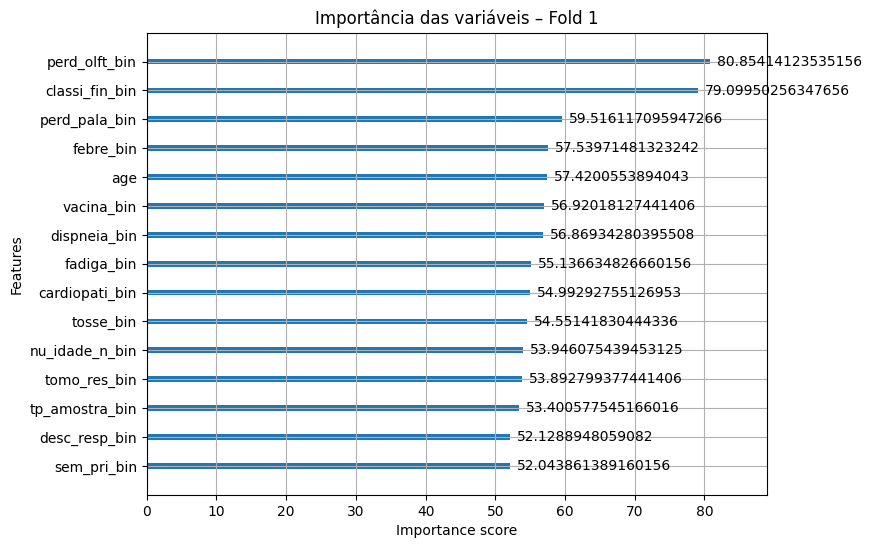

  Fold 2:


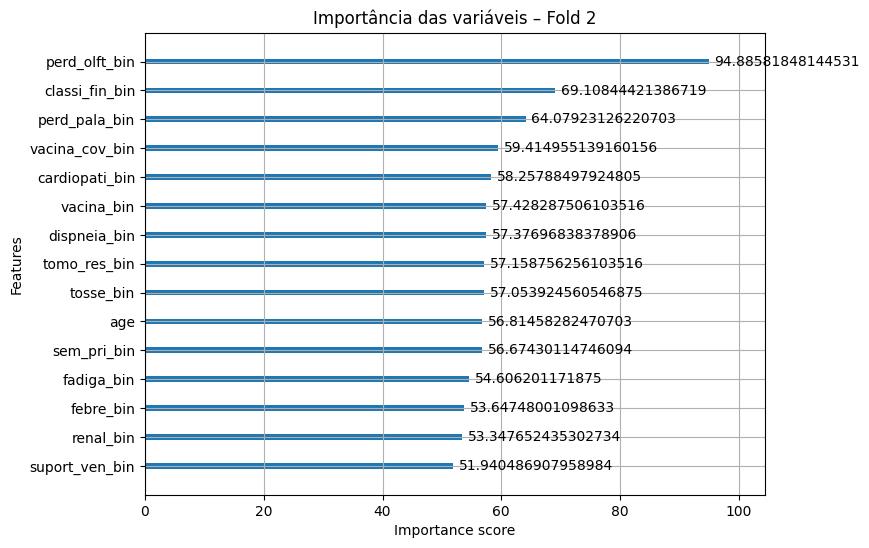

  Fold 3:


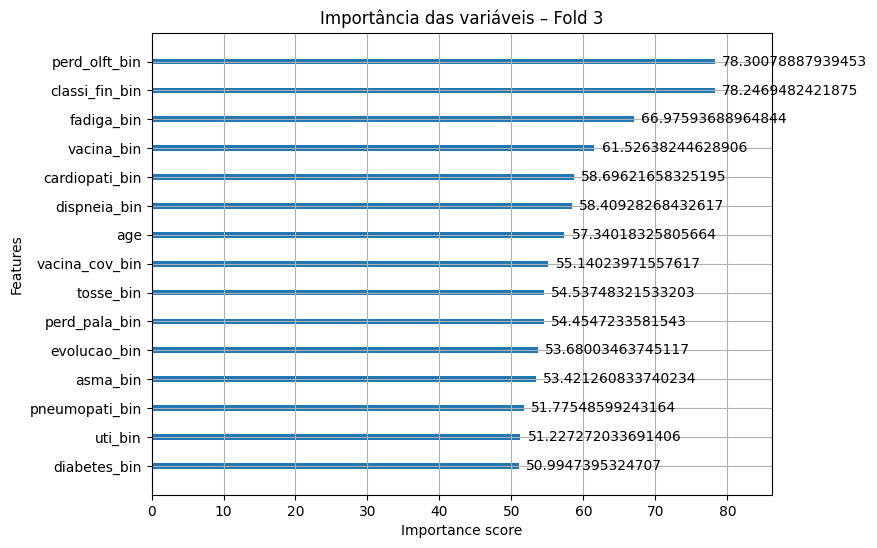

  Fold 4:


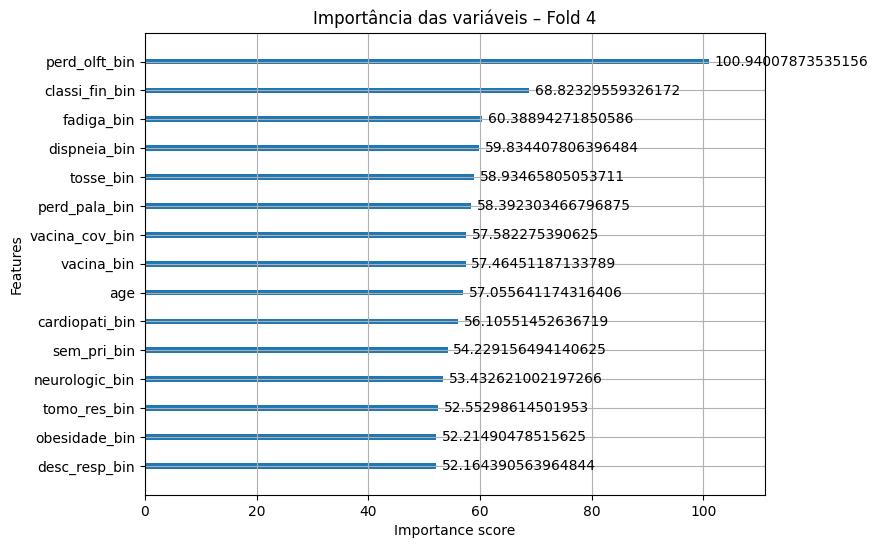

  Fold 5:


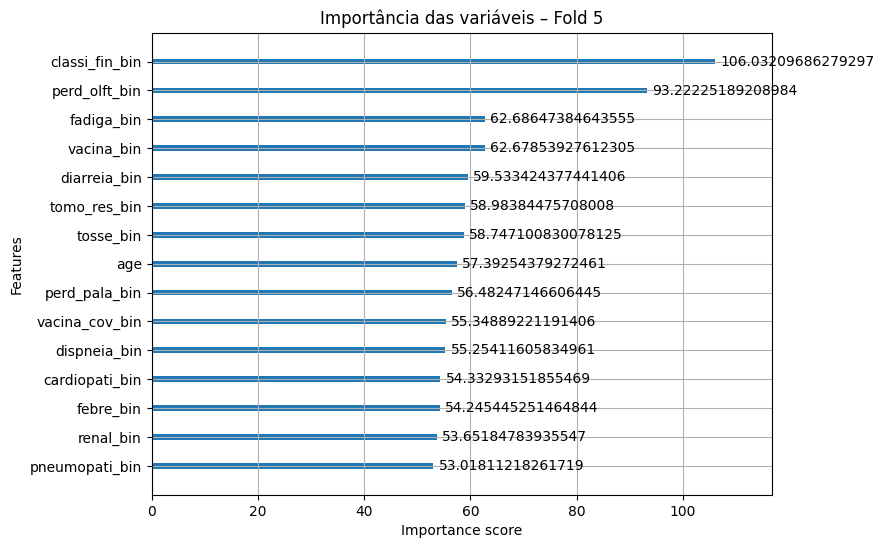

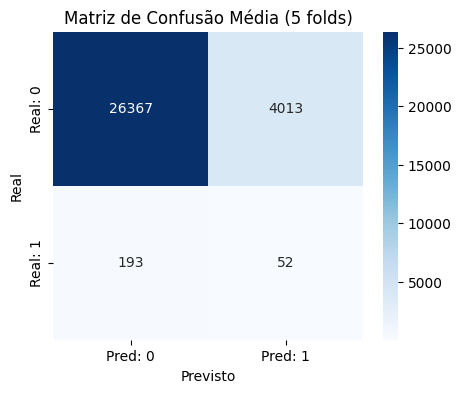

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Carregar o dataset
df = pd.read_csv("/tmp/influd_fg/influd_compacted.csv")
df.columns = [c.lower() for c in df.columns]

# Manter apenas pacientes com antiviral 1 ou 2
df = df[df["tp_antivir"].isin([1, 2])].copy()
print(f"Casos válidos (antivirais 1 ou 2): {len(df)}")

# Definir variáveis
y = df["tp_antivir"] - 1 # 1 = Oseltamivir -> 0, 2 = Zanamivir -> 1

# Remove colunas redundantes ou que não devem entrar no modelo
remove_cols = [
    "tp_antivir", "event_type", "duration",
    "oseltamivir", "zanamivir"  # redundantes
]
X = df.drop(columns=[c for c in remove_cols if c in df.columns])

# Converter variáveis categóricas para dummies
cat_cols = X.select_dtypes(include=["object"]).columns
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Preencher valores faltantes
X = X.fillna(X.median(numeric_only=True))

# Configurar Stratified K-Fold
n_splits = 5  # Número de folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Listas para armazenar métricas de cada fold
accuracy_scores = []
confusion_matrices = []
classification_reports = []
importance_plots = [] # Para armazenar figuras de importância

# Treinar e avaliar o modelo em cada fold
print(f"\nIniciando validação cruzada com {n_splits} folds...")

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Calcular pesos das classes para o fold atual
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))
    print("Pesos das classes no fold:", class_weights)

    # Treinar modelo (multiclasse) com pesos
    model_xgb = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )

    # Aplicar pesos por amostra no fit
    sample_weights = y_train.apply(lambda x: class_weights[x])

    model_xgb.fit(X_train, y_train, sample_weight=sample_weights)

    # Avaliação do fold
    y_pred = model_xgb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)
    print(f"Acurácia do Fold {fold+1}: {acc:.3f}")

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    confusion_matrices.append(cm)
    print("Matriz de Confusão do Fold", fold+1, ":\n", cm)

    report = classification_report(
        y_test, y_pred,
        target_names=["Oseltamivir (0)", "Zanamivir (1)"],
        output_dict=True
    )
    classification_reports.append(report)
    print("Relatório de Classificação do Fold", fold+1, ":\n", classification_report(y_test, y_pred, target_names=["Oseltamivir (0)", "Zanamivir (1)"]))

    # Armazenar figura de importância das variáveis para este fold
    fig_importance, ax_importance = plt.subplots(figsize=(8, 6))
    xgb.plot_importance(model_xgb, max_num_features=15, importance_type="gain", ax=ax_importance)
    ax_importance.set_title(f"Importância das variáveis – Fold {fold+1}")
    importance_plots.append(fig_importance)
    plt.close(fig_importance) # Fecha a figura para não exibir imediatamente

# Apresentar resultados agregados da validação cruzada
print("\n=== Resultados Agregados da Validação Cruzada ===")
print(f"Acurácia Média ({n_splits} folds): {np.mean(accuracy_scores):.3f} (+/- {np.std(accuracy_scores):.3f})")

# Média das matrizes de confusão
mean_cm = np.mean(confusion_matrices, axis=0).astype(int)
print("\nMatriz de Confusão Média (arredondada):\n", mean_cm)

# Média dos relatórios de classificação (ex: precision, recall, f1-score)
mean_f1_class1 = np.mean([r['Zanamivir (1)']['f1-score'] for r in classification_reports])
print(f"\nF1-score Médio para Zanamivir (1): {mean_f1_class1:.3f}")

# Exibir as figuras de importância das variáveis para cada fold
print("\nImportância das variáveis por Fold:")
for fold, fig in enumerate(importance_plots):
    print(f"  Fold {fold+1}:")
    display(fig) # Exibe a figura armazenada

# Matriz de confusão Média
plt.figure(figsize=(5, 4))
sns.heatmap(
    mean_cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["Real: 0", "Real: 1"]
)
plt.title(f"Matriz de Confusão Média ({n_splits} folds)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
# Removendo a importação de xgboost já que estamos focando no MLP
# import xgboost as xgb

# Carregar o dataset
df = pd.read_csv("/tmp/influd_fg/influd_compacted.csv")
df.columns = [c.lower() for c in df.columns]

# Manter apenas pacientes com antiviral 1 ou 2
df = df[df["tp_antivir"].isin([1, 2])].copy()
print(f"Casos válidos (antivirais 1 ou 2): {len(df)}")

# Definir variáveis
y = df["tp_antivir"] - 1 # 1 = Oseltamivir -> 0, 2 = Zanamivir -> 1

# Remove colunas redundantes ou que não devem entrar no modelo
remove_cols = [
    "tp_antivir", "event_type", "duration",
    "oseltamivir", "zanamivir"  # redundantes
]
X = df.drop(columns=[c for c in remove_cols if c in df.columns])

# Converter variáveis categóricas para dummies
cat_cols = X.select_dtypes(include=["object"]).columns
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Preencher valores faltantes (usando a média, ou pode-se considerar outra estratégia)
X = X.fillna(X.median(numeric_only=True))


# Configurar Stratified K-Fold
n_splits = 5  # Número de folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Listas para armazenar métricas de cada fold
accuracy_scores = []
confusion_matrices = []
classification_reports = []

# Treinar e avaliar o modelo em cada fold
print(f"\nIniciando validação cruzada com {n_splits} folds (MLP)...")

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Calcular pesos das classes para o fold atual
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))
    print("Pesos das classes no fold:", class_weights)

    model_mlp = MLPClassifier(
        hidden_layer_sizes=(100, 50), # Adicionando mais uma camada escondida
        max_iter=500,              # Aumentando o número máximo de iterações
        alpha=1e-3,                # Aumentando o parâmetro de regularização L2
        solver='adam',             # Otimizador
        random_state=42,
        learning_rate_init=0.001,
        early_stopping=True,       # Parar treino se a pontuação de validação não melhorar
        n_iter_no_change=10        # Número de épocas para esperar antes de parar
    )

    model_mlp.fit(X_train, y_train) # Treino padrão

    # Avaliação do fold
    y_pred = model_mlp.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)
    print(f"Acurácia do Fold {fold+1}: {acc:.3f}")

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    confusion_matrices.append(cm)
    print("Matriz de Confusão do Fold", fold+1, ":\n", cm)

    report = classification_report(
        y_test, y_pred,
        target_names=["Oseltamivir (0)", "Zanamivir (1)"],
        output_dict=True
    )
    classification_reports.append(report)
    print("Relatório de Classificação do Fold", fold+1, ":\n", classification_report(y_test, y_pred, target_names=["Oseltamivir (0)", "Zanamivir (1)"]))

# Apresentar resultados agregados da validação cruzada
print("\n=== Resultados Agregados da Validação Cruzada (MLP) ===")
print(f"Acurácia Média ({n_splits} folds): {np.mean(accuracy_scores):.3f} (+/- {np.std(accuracy_scores):.3f})")

# Média das matrizes de confusão (pode ser útil para visualização)
mean_cm = np.mean(confusion_matrices, axis=0).astype(int)
print("\nMatriz de Confusão Média (arredondada):\n", mean_cm)

f1_scores_class1 = [r['Zanamivir (1)']['f1-score'] for r in classification_reports if 'Zanamivir (1)' in r and 'f1-score' in r['Zanamivir (1)']]
if f1_scores_class1:
    mean_f1_class1 = np.mean(f1_scores_class1)
    print(f"\nF1-score Médio para Zanamivir (1): {mean_f1_class1:.3f}")
else:
    print("\nNão foi possível calcular o F1-score médio para Zanamivir (1) pois a classe não apareceu nos relatórios ou F1-score não disponível.")

# Matriz de confusão Média (Visualização)
plt.figure(figsize=(5, 4))
sns.heatmap(
    mean_cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["Real: 0", "Real: 1"]
)
plt.title(f"Matriz de Confusão Média ({n_splits} folds - MLP)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

Casos válidos (antivirais 1 ou 2): 153129

Iniciando validação cruzada com 5 folds (MLP)...

--- Fold 1/5 ---
Pesos das classes no fold: {np.int64(0): np.float64(0.5040446017116524), np.int64(1): np.float64(62.31078331637843)}
Acurácia do Fold 1: 0.992
Matriz de Confusão do Fold 1 :
 [[30381     0]
 [  245     0]]
Relatório de Classificação do Fold 1 :
                  precision    recall  f1-score   support

Oseltamivir (0)       0.99      1.00      1.00     30381
  Zanamivir (1)       0.00      0.00      0.00       245

       accuracy                           0.99     30626
      macro avg       0.50      0.50      0.50     30626
   weighted avg       0.98      0.99      0.99     30626


--- Fold 2/5 ---
Pesos das classes no fold: {np.int64(0): np.float64(0.5040404539133154), np.int64(1): np.float64(62.37423625254583)}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Acurácia do Fold 2: 0.992
Matriz de Confusão do Fold 2 :
 [[30380     0]
 [  246     0]]
Relatório de Classificação do Fold 2 :
                  precision    recall  f1-score   support

Oseltamivir (0)       0.99      1.00      1.00     30380
  Zanamivir (1)       0.00      0.00      0.00       246

       accuracy                           0.99     30626
      macro avg       0.50      0.50      0.50     30626
   weighted avg       0.98      0.99      0.99     30626


--- Fold 3/5 ---
Pesos das classes no fold: {np.int64(0): np.float64(0.5040404539133154), np.int64(1): np.float64(62.37423625254583)}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Acurácia do Fold 3: 0.992
Matriz de Confusão do Fold 3 :
 [[30380     0]
 [  246     0]]
Relatório de Classificação do Fold 3 :
                  precision    recall  f1-score   support

Oseltamivir (0)       0.99      1.00      1.00     30380
  Zanamivir (1)       0.00      0.00      0.00       246

       accuracy                           0.99     30626
      macro avg       0.50      0.50      0.50     30626
   weighted avg       0.98      0.99      0.99     30626


--- Fold 4/5 ---
Pesos das classes no fold: {np.int64(0): np.float64(0.5040404539133154), np.int64(1): np.float64(62.37423625254583)}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Acurácia do Fold 4: 0.992
Matriz de Confusão do Fold 4 :
 [[30380     0]
 [  246     0]]
Relatório de Classificação do Fold 4 :
                  precision    recall  f1-score   support

Oseltamivir (0)       0.99      1.00      1.00     30380
  Zanamivir (1)       0.00      0.00      0.00       246

       accuracy                           0.99     30626
      macro avg       0.50      0.50      0.50     30626
   weighted avg       0.98      0.99      0.99     30626


--- Fold 5/5 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Pesos das classes no fold: {np.int64(0): np.float64(0.5040445684285021), np.int64(1): np.float64(62.311291963377414)}
